In [1]:
import os
import cv2
import numpy as np  
import pandas as pd   
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tqdm import tqdm
import warnings

In [2]:
%%capture
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

In [3]:
train_path = "/kaggle/input/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/training/"
output_resized_train_path = "/kaggle/working/resized/resized_train"
split_train_path='/kaggle/working/train'
split_val_path='/kaggle/working/val'

img_types = ['.jpg', '.png', '.jpeg','.JPG', '.PNG', '.JPEG']

In [4]:
# Put output into a scrollable box
from IPython.display import display, HTML

def create_scrollable_output(output, height='300px'):
    display(HTML(
        '<div style="max-height: {0}; overflow-y: auto;"><pre>{1}</pre></div>'.format(height, output)
    ))

In [5]:
# Delete if it's already exis when creating a new folder
def recreate_dir(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

In [6]:
warnings.filterwarnings("ignore", category=UserWarning)

def traverse_folders(path):
    output = ""
    for folder_name in sorted(os.listdir(path)):
        output += 'Folder name: ' + folder_name + "\n"
        
        img_data = []
        df = pd.DataFrame(columns=['path', 'width', 'height'])
        

        image_files = [file_name for file_name in sorted(os.listdir(os.path.join(path, folder_name))) 
                       if file_name.endswith(tuple(img_types))]
        
        #print(image_files)
        
        for image_file in image_files:
            img_path=os.path.join(path, folder_name, image_file)
            with Image.open(img_path) as img:
                width, height = img.size
            img_data.append({'path': img_path, 'width': width, 'height': height})        

        df = pd.concat([df, pd.DataFrame(img_data)], ignore_index=True)

        width_desc = df['width'].astype(int).describe()
        height_desc = df['height'].astype(int).describe()
        
        output += "Count: {}\n".format(int(width_desc['count']))
        output += "Width -  min: {}, max: {}\n".format(width_desc['min'], width_desc['max'])
        output += "Height -  min: {}, max: {}\n".format(height_desc['min'], height_desc['max'])
        output += '------------------\n'
    
    return output

scrollable_output = traverse_folders(train_path)
create_scrollable_output(scrollable_output)


In [8]:
'''Check images size (min/max-width/height) in the folder'''
def get_min_max_size(path):

    folders = sorted([folder for folder in os.listdir(path)])

    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0

    for folder_name in folders:
        image_files = [file_name for file_name in os.listdir(os.path.join(path, folder_name)) 
                       if file_name.endswith(tuple(img_types))]

        for image_file in image_files:
            with Image.open(os.path.join(path, folder_name, image_file)) as img:
                width, height = img.size

                min_width = min(min_width, width)
                min_height = min(min_height, height)
                max_width = max(max_width, width)
                max_height = max(max_height, height)

    print("Minimum width: ", min_width, "  Minimum height: ", min_height)
    print("Maximum width: ", max_width, "  Maximum height: ", max_height)
    
get_min_max_size(train_path)

Minimum width:  750   Minimum height:  1334
Maximum width:  4208   Maximum height:  4608


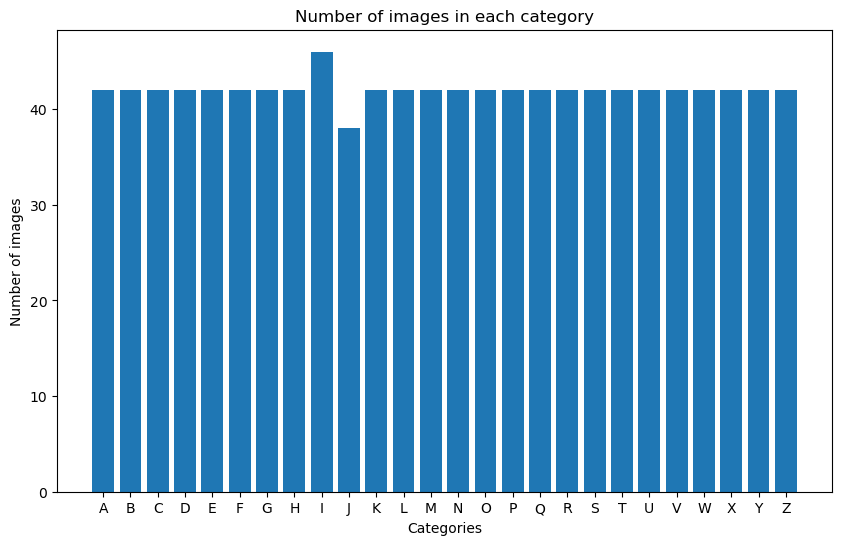

In [9]:
'''Look at the number of images in each folder'''
path=train_path
#path='/kaggle/working/val'

categories = sorted(os.listdir(path))

image_counts = [len([f for f in os.listdir(os.path.join(path, category)) 
                     if f.endswith(tuple(img_types))]) for category in categories]

plt.figure(figsize=(10,6)) 
plt.bar(categories, image_counts)
plt.xlabel("Categories")
plt.ylabel("Number of images")
plt.title("Number of images in each category")
plt.show()


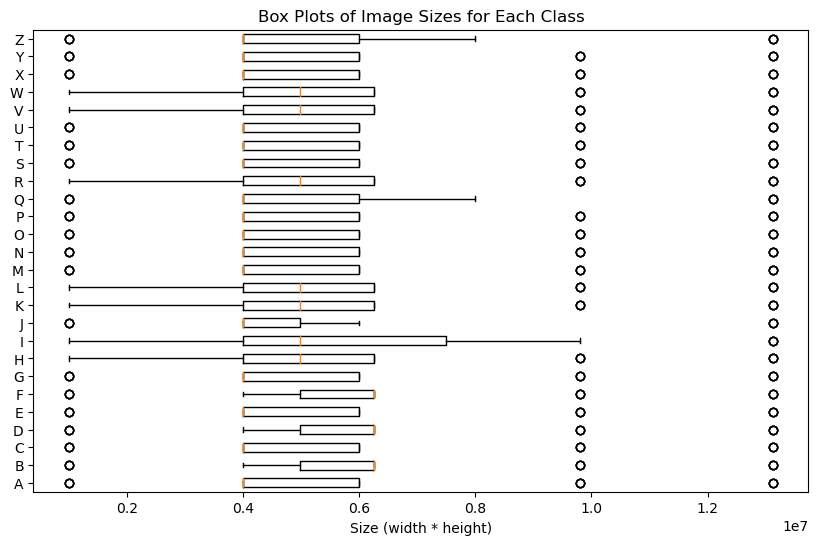

In [10]:
# Look at the imgs size

base_dir = train_path
folders = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

data = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    sizes = []
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        with Image.open(image_path) as img:
            width, height = img.size
            sizes.append(width * height)  # Consider the area as size 
    data.append(sizes)

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=folders, vert=False)  # Use `vert=False` for horizontal box plots
plt.xlabel('Size (width * height)')
plt.title('Box Plots of Image Sizes for Each Class')
plt.show()

In [11]:
'''Split train/test set'''
def split_train_test_dataset(base_dir,train_dir,test_dir,split_ratio = 0.8):
    
    recreate_dir(train_dir)
    recreate_dir(test_dir)

    for category in os.listdir(base_dir):
        category_dir = os.path.join(base_dir, category)
        train_category_dir = os.path.join(train_dir, category)
        test_category_dir = os.path.join(test_dir, category)

        recreate_dir(train_category_dir)
        recreate_dir(test_category_dir)

        images = [f for f in os.listdir(category_dir) if f.endswith(tuple(img_types))]
        np.random.shuffle(images)


        for i, img in enumerate(images):
            if i < int(len(images) * split_ratio):
                destination = train_category_dir
            else:
                destination = test_category_dir

            #recreate_dir(destination)
            shutil.copy(os.path.join(category_dir, img), os.path.join(destination, img))
    print('Finished.')


split_train_test_dataset(train_path,split_train_path,split_val_path, 0.8)

Finished.


In [12]:
'''--xxx--  Abandoned. Because we will adjust the size later when doing data augmentation'''
'''Resize Images'''
def resize_images(image_dir, output_dir, size=(224, 224)):
    recreate_dir(output_dir)
      
    for category in sorted(os.listdir(image_dir)):
        category_dir = os.path.join(image_dir, category)
        output_category_dir = os.path.join(output_dir, category)
        
        recreate_dir(output_category_dir)
            
        print('Begin to resize folder: ',category_dir)
        for image_name in sorted(os.listdir(category_dir)):
            if image_name.endswith(tuple(img_types)):
                image_path = os.path.join(category_dir, image_name)
                img = Image.open(image_path)
                # thumbnail v.s resize : https://stackoverflow.com/questions/29367990/what-is-the-difference-between-image-resize-and-image-thumbnail-in-pillow-python
                img.thumbnail(size, Image.LANCZOS)
                
                new_img = Image.new("RGB", size)  # create a new black image
                new_img.paste(img, ((size[0] - img.size[0]) // 2,
                                  (size[1] - img.size[1]) // 2))  # paste resized image into center of new image
                
                new_img.save(os.path.join(output_category_dir, image_name))
        print('Finished resize folder: ',category_dir)

#resize_images(train_path, output_resized_train_path)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms


import copy
import time


In [14]:
'''Calculate the mean and standard deviation of trainning set '''

transform = transforms.Compose([transforms.ToTensor()])

dataset = datasets.ImageFolder(root=split_train_path, transform=transform)

# 初始化总的均值和标准差为0
total_mean = torch.zeros(3)
total_std = torch.zeros(3)

# 计算所有图像的均值和标准差 
for img, _ in tqdm(dataset):
    total_mean += torch.mean(img, dim=[1,2])
    total_std += torch.std(img, dim=[1,2])

# 求均值和标准差的平均值
mean = total_mean / len(dataset)
std = total_std / len(dataset)

# 输出均值和标准差
print(mean, std)

mean_list = mean.tolist()
std_list = std.tolist()


100%|██████████| 858/858 [04:22<00:00,  3.27it/s]


tensor([0.5370, 0.4982, 0.4813]) tensor([0.1859, 0.2076, 0.2259])


In [16]:
'''Transform, ImageFolder, DataLoader: https://medium.com/jun94-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0'''
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Resize randomly
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_list, std_list) 
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # Resize from center 
        transforms.ToTensor(),
        transforms.Normalize(mean_list, std_list)
    ]),
}


In [17]:
image_datasets = {
    'train': datasets.ImageFolder(split_train_path, data_transforms['train']),
    'val': datasets.ImageFolder(split_val_path, data_transforms['val'])
}
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16, shuffle=True, num_workers=4)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


【Way-1】Using models.googlenet and GoogLeNet_Weights

In [47]:
from torchvision.models import GoogLeNet_Weights

model_ft = models.googlenet(weights=("pretrained", GoogLeNet_Weights.IMAGENET1K_V1))
#model_ft = models.googlenet(pretrained=True)
#model_ft = models.googlenet(pretrained=False, init_weights=True)

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to be the number of classes
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)


In [48]:
# The 7 Most Common Machine Learning Loss Functions: https://builtin.com/machine-learning/common-loss-functions
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [49]:
from torchvision.models.googlenet import GoogLeNetOutputs

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # .zero_grad(): https://blog.csdn.net/weixin_39504171/article/details/103179067
                optimizer.zero_grad()

                # .set_grad_enabled() : https://blog.csdn.net/qq_35037684/article/details/118958253
                with torch.set_grad_enabled(phase == 'train'):# track history if only in train
                    outputs = model(inputs)
                    
                    '''
                    加这句是因为前面如果设置了GoogLeNet模型在Torchvision库中的实现有两种输出方式，
                    用预训练的模型时，即pretrained=True或者weights=("pretrained", GoogLeNet_Weights.IMAGENET1K_V1)，模型会返回一个单一的输出，
                    这是因为预训练模型是用来进行图像分类的，所以输出的是一个形状为(batch_size, num_classes)的张量。
                    而用pretrained=False也就是前面设置的model_ft = models.googlenet(pretrained=False, init_weights=True)来从头开始训练模型时，
                    模型会返回一个GoogLeNetOutputs对象。这个对象包含了模型中间层的输出，主要用于训练过程中的辅助分类。
                    具体来说，GoogLeNetOutputs包含以下三个属性：logits，aux_logits2，aux_logits1，分别对应于主分类器的输出和两个辅助分类器的输出。
                    因此，在训练过程中需要判断模型的输出是一个张量还是一个GoogLeNetOutputs对象。如果是后者，应该使用主分类器的输出（即logits）来计算损失。
                    
                    '''
                    if isinstance(outputs, GoogLeNetOutputs):
                        outputs = outputs.logits
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [50]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------
train Loss: 3.2732 Acc: 0.0478
val Loss: 3.1666 Acc: 0.1325

Epoch 1/9
----------
train Loss: 3.1741 Acc: 0.1072
val Loss: 3.0374 Acc: 0.2222

Epoch 2/9
----------
train Loss: 3.0492 Acc: 0.1655
val Loss: 2.8428 Acc: 0.3632

Epoch 3/9
----------
train Loss: 2.9032 Acc: 0.2587
val Loss: 2.5826 Acc: 0.4188

Epoch 4/9
----------
train Loss: 2.7352 Acc: 0.3240
val Loss: 2.3505 Acc: 0.5043

Epoch 5/9
----------
train Loss: 2.5326 Acc: 0.3800
val Loss: 2.0690 Acc: 0.5128

Epoch 6/9
----------
train Loss: 2.3390 Acc: 0.4336
val Loss: 1.7866 Acc: 0.6239

Epoch 7/9
----------
train Loss: 2.2372 Acc: 0.4872
val Loss: 1.7789 Acc: 0.6453

Epoch 8/9
----------
train Loss: 2.1877 Acc: 0.4825
val Loss: 1.7415 Acc: 0.6538

Epoch 9/9
----------
train Loss: 2.1731 Acc: 0.4965
val Loss: 1.7162 Acc: 0.6410

Training complete in 9m 31s
Best val Acc: 0.653846


In [ ]:
# Ensure the model is in eval mode
model_ft.eval()

# Open the image
img = Image.open('/kaggle/input/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_V02/test/N (4).jpg')

# Preprocess the image
img_transformed = data_transforms['val'](img)
img_transformed = img_transformed.unsqueeze(0).to(device)

# Make a prediction
out = model_ft(img_transformed)

# Get the predicted class
_, preds = torch.max(out, 1)

print("Predicted class: ", class_names[preds.item()])

 Buile a GoogLeNet from scratch 

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):  # adjust num_classes according to your problem
        super(GoogLeNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
